## Gemini testing

Brief test to see, whether Gemini is able to infer the company, sector or year, from raw financial data only.
Even if Gemini has, at some point, seen financial statements from the underlying companbies, I strongly assume it will not be able to infer them from
the financial statements I downloaded, since they were normalized and therefore represent new information.

In [102]:
import pandas as pd
import numpy as np 
from google import genai
from google.genai import types
import json
import re
from tqdm import tqdm
import time
from google.genai.errors import ServerError  
from fuzzywuzzy import fuzz

In [2]:
# Import Gemini API key
with open("../proton_google_api_key.txt", "r") as f:
    key = f.read().strip()    

# Initialize the Gemini client with the API key
client = genai.Client(api_key = key)

In [3]:
labeled_balance_sheets = pd.read_csv("../data/balance_sheets_with_labels.csv", dtype={"CIK": str})
labeled_income_statements = pd.read_csv("../data/income_statements_with_labels.csv", dtype={"CIK": str})
labeled_cash_flow_statements = pd.read_csv("../data/cash_flow_statements_with_labels.csv", dtype={"CIK": str})
# Data on economic sectors of S&P 1500 companies
sectors = pd.read_csv("../data/sp1500_market_sectors.csv", dtype={"cik": str})

C:\Users\benny\AppData\Local\Temp\ipykernel_32208\4175993906.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labeled_income_statements = pd.read_csv("../data/income_statements_with_labels.csv", dtype={"CIK": str})
C:\Users\benny\AppData\Local\Temp\ipykernel_32208\4175993906.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labeled_cash_flow_statements = pd.read_csv("../data/cash_flow_statements_with_labels.csv", dtype={"CIK": str})


In [4]:
merged_balance_sheets = pd.merge(labeled_balance_sheets, sectors, left_on="CIK", right_on="cik", how="left").drop(columns=["cik"])
merged_income_statements = pd.merge(labeled_income_statements, sectors, left_on="CIK", right_on="cik", how="left").drop(columns=["cik"])
merged_cash_flow_statements = pd.merge(labeled_cash_flow_statements, sectors, left_on="CIK", right_on="cik", how="left").drop(columns=["cik"])

In [5]:
# First determine unique CIKs
full_cik_set = set(labeled_balance_sheets["CIK"].unique()) | set(labeled_income_statements["CIK"].unique()) | set(labeled_cash_flow_statements["CIK"].unique())

# Convert to DataFrame to make slicing into equal parts easier
ciks = list(full_cik_set)

In [6]:
# Determin minimum and maximum year as input for Gemini
all_years = pd.concat([
    merged_balance_sheets["Date"],
    merged_income_statements["Date"],
    merged_cash_flow_statements["Date"]
])
# Convert do datetime for min/max
all_years = pd.to_datetime(all_years)
# Grab only the year
min_year = all_years.dt.year.min()
max_year = all_years.dt.year.max()
print(min_year, max_year)

1998 2024


In [ ]:
def gemini_infer(cik: str, balance_sheets = None, income_statements = None, cash_flow_statements = None):
    """
    Function that queries Gemini to infer:
    - Company name
    - Economic Sector of operation
    - Year of the financial statements
    from raw, normalized and anonymized financial statements only. 

    Parameters: 
    cik: str, CIK of the company (Can be looked up on the SEC website)
    balance_sheets: Balance Sheets DataFrame with columns: STD Balance Sheet All, FCC Item Name, CIK and Date (among others)
    income_statements: Income Statements DataFrame with columns: STD Income Statement All, FCC Item Name, CIK and Date (among others)
    cash_flow_statements: Cash Flow Statements DataFrame with columns: STD Cash Flow All, FCC Item Name, CIK and Date (among others)
    """
    
    # First filter dfs for input CIK
    balance_sheets = balance_sheets[balance_sheets["CIK"] == cik].copy()
    income_statements = income_statements[income_statements["CIK"] == cik].copy()
    cash_flow_statements = cash_flow_statements[cash_flow_statements["CIK"] == cik].copy()
    
    # Grab RIC and sector for identification
    ric = balance_sheets["RIC"].unique()[0]
    sector = balance_sheets["sector"].unique()[0]
    
    # Convert the date columns to datetime objects
    for df in [balance_sheets, income_statements, cash_flow_statements]:
        df["Report Date"] = pd.to_datetime(df["Date"])

    # Determine unique dates
    reporting_dates = pd.concat([
        balance_sheets["Report Date"],
        income_statements["Report Date"],
        cash_flow_statements["Report Date"]
    ]).unique()
    
    # In order to handle reports, that were filed slighty apart, a window of 10 days around a given reporting date is used
    window = pd.Timedelta(days=10)
    
    # Sort dates
    reporting_dates = np.sort(reporting_dates)
    # Create empty set to track already attempted dates
    attempted_dates = set()

    # Randomly sample reporting dates until one is found, for which all three reports are available
    while len(attempted_dates) < len(reporting_dates):
        date = pd.to_datetime(np.random.choice(reporting_dates, size=1)[0])
        if date in attempted_dates:
            continue # continues at top of while loop
        attempted_dates.add(date)
        # Filter reports for the given date +/- window
        bs = balance_sheets[(balance_sheets["Report Date"] >= date - window) &
                            (balance_sheets["Report Date"] <= date + window)]
        is_0 = income_statements[(income_statements["Report Date"] >= date - window) &
                                (income_statements["Report Date"] <= date + window)]
        cf_0 = cash_flow_statements[(cash_flow_statements["Report Date"] >= date - window) &
                                    (cash_flow_statements["Report Date"] <= date + window)]
        # If all three reports are non-empty, we can proceed
        if not bs.empty and not is_0.empty and not cf_0.empty:
            break  # valid date found, continue at next line after while loop

    else: # else clause belongs to while loop, only executed if while loop is not broken out of via 'break'
        print(f"No valid reporting date found for CIK {cik}. Skipping...")
        return None
    
    # Concatenate reports into strings with correct labels
    bs_str = "\n".join(bs.apply(lambda row: f"{row['position_label']}: {row['STD Balance Sheet All']}", axis=1).astype(str))
    is_str = "\n".join(is_0.apply(lambda row: f"{row['position_label']}: {row['STD Income Statement All']}", axis=1).astype(str))
    cf_str = "\n".join(cf_0.apply(lambda row: f"{row['position_label']}: {row['STD Cash Flow All']}", axis=1).astype(str))        

    # Call the LLM to get the rating
    response = client.models.generate_content(
        # model="gemini-2.5-flash", 
        model="gemini-2.5-flash-lite",
        config=types.GenerateContentConfig(
            temperature=0, # Deterministic ouput
            system_instruction="""You are an experienced, data-driven financial analyst, that provides concise and accurate answers.""",
            
            thinking_config=types.ThinkingConfig(thinking_budget=0),
        ),
        
        contents=[f"""
        Based on the following financial reports only, please infer the company name, economic sector and year, in which the balance sheet was published.
                    
        Balance Sheet: 
        {bs_str}

        Income Statement: 
        {is_str}

        Cash Flow Statement: 
        {cf_str}

        The possible sectors are:
        {sectors['sector'].unique().tolist()}
        The possible companies are all companies that are part of the S&P 1500 index as of July 2025.
        The possible years are any year in the range from {min_year} to {max_year + 1}.

        Please provide your answer in the following dictionary style format:
        {{
            "company_name": <Company Name>,
            "sector": <Economic Sector>,
            "year": <Year of the balance sheet>
        }}

        If you are uncertain about your answers, provide the best guess.
        It is imperative to stick to the dictionary style answer format and not provide any reasoning.
        """]
    )

    # Extract rating from the response
    result = response.text.strip()
    # Remove Markdown fences if present (?)
    result = re.sub(r"^```json\s*|\s*```$", "", result, flags=re.DOTALL).strip()

    # Try to parse the result as a dictionary
    try:
        result = json.loads(result)
    except json.JSONDecodeError:
        print(f"Could not parse result for CIK {cik} on date {date}. Result was: {result}")
        return None
    
    # Append results to list
    result_dict = {
        "CIK": cik,
        "RIC": ric,
        "actual_year": date.year,
        "actual_sector": sector, 
        "inferred_company_name": result.get("company_name"),
        "inferred_sector": result.get("sector"),
        "inferred_year": result.get("year"),
        "no_retries": len(attempted_dates) - 1 
    }

    return result_dict

In [ ]:
def gemini_infer_with_previous_quarters(cik: str, balance_sheets = None, income_statements = None, cash_flow_statements = None):
    """
    Function that queries Gemini to infer:
    - Company name
    - Economic Sector of operation
    - Year of the financial statements
    from raw, normalized and anonymized financial statements only. In order to make the task more realistic, the function fetches not only the most recent
    financial statements, but also those of the 3 previous quarters (if available).

    Parameters: 
    cik: str, CIK of the company (Can be looked up on the SEC website)
    balance_sheets: Balance Sheets DataFrame with columns: STD Balance Sheet All, FCC Item Name, CIK and Date (among others)
    income_statements: Income Statements DataFrame with columns: STD Income Statement All, FCC Item Name, CIK and Date (among others)
    cash_flow_statements: Cash Flow Statements DataFrame with columns: STD Cash Flow All, FCC Item Name, CIK and Date (among others)
    """
    
    # First filter dfs for input CIK
    balance_sheets = balance_sheets[balance_sheets["CIK"] == cik].copy()
    income_statements = income_statements[income_statements["CIK"] == cik].copy()
    cash_flow_statements = cash_flow_statements[cash_flow_statements["CIK"] == cik].copy()
    
    # Grab RIC and sector for identification
    ric = balance_sheets["RIC"].unique()[0]
    sector = balance_sheets["sector"].unique()[0]
    
    # Convert the date columns to datetime objects
    for df in [balance_sheets, income_statements, cash_flow_statements]:
        df["Report Date"] = pd.to_datetime(df["Date"])

    # Determine unique dates
    reporting_dates = pd.concat([
        balance_sheets["Report Date"],
        income_statements["Report Date"],
        cash_flow_statements["Report Date"]
    ]).unique()
    
    # In order to handle reports, that were filed slighty apart, a window of 10 days around a given reporting date is used
    window = pd.Timedelta(days=10)
    
    # Sort dates
    reporting_dates = np.sort(reporting_dates)
    # Create empty set to track already attempted dates
    attempted_dates = set()

    # Randomly sample reporting dates until one is found, for which all three reports are available
    # Remark to previous function: I still only check for availability of reports for t0, not for previous quarters
    # If previous quarters are available, information will be appended, if not, the function will proceed nonetheless
    while len(attempted_dates) < len(reporting_dates):
        date = pd.to_datetime(np.random.choice(reporting_dates, size=1)[0])
        if date in attempted_dates:
            continue # continues at top of while loop
        attempted_dates.add(date)
        # Filter reports for the given date +/- window
        bs = balance_sheets[(balance_sheets["Report Date"] >= date - window) &
                            (balance_sheets["Report Date"] <= date + window)]
        is_0 = income_statements[(income_statements["Report Date"] >= date - window) &
                                (income_statements["Report Date"] <= date + window)]
        cf_0 = cash_flow_statements[(cash_flow_statements["Report Date"] >= date - window) &
                                    (cash_flow_statements["Report Date"] <= date + window)]
        # If all three reports are non-empty, we can proceed
        if not bs.empty and not is_0.empty and not cf_0.empty:
            break  # valid date found, continue at next line after while loop

    else: # else clause belongs to while loop, only executed if while loop is not broken out of via 'break'
        print(f"No valid reporting date found for CIK {cik}. Skipping...")
        return None
    
 
    # Determine current date
    q0_date = date
    # Determine date of previous quarter
    qminus1_date = date - pd.DateOffset(months=3)
    # Determine date of q0 -2 
    qminus2_date = date - pd.DateOffset(months=6)
    # Determine date of q0 -3
    qminus3_date = date - pd.DateOffset(months=9)        


    # Subset all financial statements for the given dates +- window days
    # Current quarter
    bs = balance_sheets[
        (balance_sheets["Report Date"] >= date - window) &
        (balance_sheets["Report Date"] <= date + window)
    ]
    is_0 = income_statements[
        (income_statements["Report Date"] >= date - window) &
        (income_statements["Report Date"] <= date + window)
    ]
    cf_0 = cash_flow_statements[
        (cash_flow_statements["Report Date"] >= date - window) &
        (cash_flow_statements["Report Date"] <= date + window)
    ]

    # Previous quarter (Q-1)
    is_qminus1 = income_statements[
        (income_statements["Report Date"] >= qminus1_date - window) &
        (income_statements["Report Date"] <= qminus1_date + window)
    ]
    cf_qminus1 = cash_flow_statements[
        (cash_flow_statements["Report Date"] >= qminus1_date - window) &
        (cash_flow_statements["Report Date"] <= qminus1_date + window)
    ]

    # Two quarters ago (Q-2)
    is_qminus2 = income_statements[
        (income_statements["Report Date"] >= qminus2_date - window) &
        (income_statements["Report Date"] <= qminus2_date + window)
    ]
    cf_qminus2 = cash_flow_statements[
        (cash_flow_statements["Report Date"] >= qminus2_date - window) &
        (cash_flow_statements["Report Date"] <= qminus2_date + window)
    ]

    # Three quarters ago (Q-3)
    is_qminus3 = income_statements[
        (income_statements["Report Date"] >= qminus3_date - window) &
        (income_statements["Report Date"] <= qminus3_date + window)
    ]
    cf_qminus3 = cash_flow_statements[
        (cash_flow_statements["Report Date"] >= qminus3_date - window) &
        (cash_flow_statements["Report Date"] <= qminus3_date + window)
    ]

    # If no reports are available for the given date, skip to next date
    if bs.empty or is_0.empty or cf_0.empty:
        missing = []
        if bs.empty:
            missing.append("Balance Sheet")
        if is_0.empty:
            missing.append("Income Statement at Q0")
        if cf_0.empty:
            missing.append("Cash Flow Statement at Q0")
        print(f"Reports missing for date {date}: {', '.join(missing)}. Skipping...")
        return None
    
    # Concatenate reports into strings with correct labels
    bs_str = "\n".join(bs.apply(lambda row: f"{row['position_label']}: {row['STD Balance Sheet All']}", axis=1).astype(str))
    is_str = "\n".join(is_0.apply(lambda row: f"{row['position_label']}: {row['STD Income Statement All']}", axis=1).astype(str))
    cf_str = "\n".join(cf_0.apply(lambda row: f"{row['position_label']}: {row['STD Cash Flow All']}", axis=1).astype(str))

    # Append previous quarters if available — even if just one of IS or CF is present
    if not is_qminus1.empty:
        is_qminus1_str = "\n".join(is_qminus1.apply(lambda row: f"{row['position_label']}: {row['STD Income Statement All']}", axis=1).astype(str))
        is_str += f"\n\nIncome Statement from previous quarter:\n{is_qminus1_str}"
    if not cf_qminus1.empty:
        cf_qminus1_str = "\n".join(cf_qminus1.apply(lambda row: f"{row['position_label']}: {row['STD Cash Flow All']}", axis=1).astype(str))
        cf_str += f"\n\nCash Flow Statement from previous quarter:\n{cf_qminus1_str}"

    if not is_qminus2.empty:
        is_qminus2_str = "\n".join(is_qminus2.apply(lambda row: f"{row['position_label']}: {row['STD Income Statement All']}", axis=1).astype(str))
        is_str += f"\n\nIncome Statement from two quarters ago:\n{is_qminus2_str}"
    if not cf_qminus2.empty:
        cf_qminus2_str = "\n".join(cf_qminus2.apply(lambda row: f"{row['position_label']}: {row['STD Cash Flow All']}", axis=1).astype(str))
        cf_str += f"\n\nCash Flow Statement from two quarters ago:\n{cf_qminus2_str}"

    if not is_qminus3.empty:
        is_qminus3_str = "\n".join(is_qminus3.apply(lambda row: f"{row['position_label']}: {row['STD Income Statement All']}", axis=1).astype(str))
        is_str += f"\n\nIncome Statement from three quarters ago:\n{is_qminus3_str}"
    if not cf_qminus3.empty:
        cf_qminus3_str = "\n".join(cf_qminus3.apply(lambda row: f"{row['position_label']}: {row['STD Cash Flow All']}", axis=1).astype(str))
        cf_str += f"\n\nCash Flow Statement from three quarters ago:\n{cf_qminus3_str}"
        

    # Call the LLM to get the rating
    response = client.models.generate_content(
        # model="gemini-2.5-flash", 
        model="gemini-2.5-flash-lite",
        config=types.GenerateContentConfig(
            temperature=0, # Deterministic ouput
            system_instruction="""You are an experienced, data-driven financial analyst, that provides concise and accurate answers.""",
            
            thinking_config=types.ThinkingConfig(thinking_budget=0),# Disables thinking, but only required for Gemini 2.5
        ),
        
        contents=[f"""
        Based on the following financial reports only, please infer the company name, economic sector and year, in which the balance sheet was published.
                    
        Balance Sheet: 
        {bs_str}

        Income Statement: 
        {is_str}

        Cash Flow Statement: 
        {cf_str}

        The possible sectors are:
        {sectors['sector'].unique().tolist()}

        The possible years are any year in the range from {min_year} to {max_year + 1}.
        Do not default to the most recent year. Infer the year based solely on the financial figures provided.

        The possible companies are all companies that are part of the S&P 1500 index as of July 2025.
        Please provide your answer in the following dictionary style format:
        {{
            "company_name": <Company Name>,
            "sector": <Economic Sector>,
            "year": <Year of the balance sheet>
        }}
        If you are uncertain about your answers, provide the best guess.
        It is imperative to stick to the dictionary style answer format and not provide any reasoning.
        """]
    )

    # Extract rating from the response
    result = response.text.strip()
    # Remove Markdown fences if present (?)
    result = re.sub(r"^```json\s*|\s*```$", "", result, flags=re.DOTALL).strip()

    # Try to parse the result as a dictionary
    try:
        result = json.loads(result)
    except json.JSONDecodeError:
        print(f"Could not parse result for CIK {cik} on date {date}. Result was: {result}")
        return None
    
    # Append results to list
    result_dict = {
        "CIK": cik,
        "RIC": ric,
        "actual_year": date.year,
        "actual_sector": sector, 
        "inferred_company_name": result.get("company_name"),
        "inferred_sector": result.get("sector"),
        "inferred_year": result.get("year"),
        "no_retries": len(attempted_dates) - 1 # first try is not really a retry
    }
    
    return result_dict

In [9]:
# Function to loop over a list of CIKs and apply the gemini_infer functions
def gemini_infer_loop(cik_list, balance_sheets, income_statements, cash_flow_statements, function_to_use, no_requests = 10000):
    results = []
    for request in tqdm(range(no_requests)):
        # Pick random CIK
        cik = np.random.choice(cik_list, size=1)[0]
        success = False
        attempts = 0
        while not success and attempts < 5:  # Retry up to 5 times
            try:
                result = function_to_use(
                    cik=cik,
                    balance_sheets=balance_sheets,
                    income_statements=income_statements,
                    cash_flow_statements=cash_flow_statements
                )
                if result is not None:
                    results.append(result)
                success = True
            except ServerError as e:
                attempts += 1
                print(f"ServerError encountered for CIK {cik}. Attempt {attempts}/5. Error: {e}")
                time.sleep(5)  # Wait before retrying
            except Exception as e:
                print(f"Unexpected error for CIK {cik}: {e}")
                success = True  # Exit loop on unexpected errors
    return pd.DataFrame(results)

- Applying the functions

Even after playing around with the actual content sent to the model for around half a day, the model still almost always answers "2023" as the inferred year.
This is regardless of which function is used (only most recent quarters, or data going back 1 year) and invariant to the positiong/phrasing of the prompt.
Even when specifically telling the model to not simply return the most recent year, it almost exclusively returns 2023. Even when specifically telling the model to not choose 2023, it does so in a majority of queries. 

I therefore decided to focus on company sectors and names instead and will gather results for both cases:
- Including only most recent financial statements.
- Including most recent balance sheet, but income and cash flow statements going back one full year.

- Including only most recent financial statements

In [20]:
# Set seed for reproducibility
np.random.seed(42)

most_recent_quarter_results = gemini_infer_loop(
    cik_list=ciks,
    balance_sheets=merged_balance_sheets,
    income_statements=merged_income_statements,
    cash_flow_statements=merged_cash_flow_statements,
    function_to_use=gemini_infer,
    no_requests=10000
)
most_recent_quarter_results.to_csv("../data/gemini_inference_most_recent_quarter.csv", index=False)

  5%|▌         | 547/10000 [14:52<3:40:00,  1.40s/it]

No valid reporting date found for CIK 0002027317. Skipping...


  7%|▋         | 659/10000 [17:52<3:51:02,  1.48s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 13%|█▎        | 1342/10000 [36:11<3:26:11,  1.43s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 22%|██▏       | 2238/10000 [1:00:00<3:04:50,  1.43s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 22%|██▎       | 2250/10000 [1:00:19<3:07:34,  1.45s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 34%|███▍      | 3388/10000 [1:31:27<2:42:26,  1.47s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 38%|███▊      | 3757/10000 [1:41:35<2:35:41,  1.50s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 44%|████▍     | 4406/10000 [1:59:29<2:28:47,  1.60s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 48%|████▊     | 4783/10000 [2:10:00<2:12:12,  1.52s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 50%|████▉     | 4980/10000 [2:15:37<2:10:41,  1.56s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 53%|█████▎    | 5266/10000 [2:23:44<1:59:31,  1.51s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 54%|█████▎    | 5372/10000 [2:26:47<2:04:04,  1.61s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 59%|█████▉    | 5905/10000 [2:41:59<1:47:16,  1.57s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 63%|██████▎   | 6329/10000 [2:53:58<1:29:21,  1.46s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 65%|██████▍   | 6476/10000 [2:58:08<1:33:30,  1.59s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 71%|███████   | 7118/10000 [3:16:06<1:13:13,  1.52s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 77%|███████▋  | 7705/10000 [3:32:41<1:00:12,  1.57s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 77%|███████▋  | 7737/10000 [3:33:35<1:00:18,  1.60s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 78%|███████▊  | 7768/10000 [3:34:26<59:02,  1.59s/it]  

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 79%|███████▉  | 7928/10000 [3:38:56<53:25,  1.55s/it]  

No valid reporting date found for CIK 0002027317. Skipping...


 81%|████████  | 8124/10000 [3:44:31<48:38,  1.56s/it]  

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 85%|████████▍ | 8458/10000 [3:53:34<38:12,  1.49s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 89%|████████▊ | 8869/10000 [4:05:06<29:09,  1.55s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 89%|████████▉ | 8906/10000 [4:06:06<26:08,  1.43s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 95%|█████████▍| 9495/10000 [4:23:41<12:56,  1.54s/it]

No valid reporting date found for CIK 0002015845. Skipping...


100%|██████████| 10000/10000 [4:44:11<00:00,  1.71s/it]


In [23]:
most_recent_quarter_results["inferred_year"].value_counts()

inferred_year
2023    9832
2024      35
N/A       14
2025      13
2017      13
2003      11
2007       9
2005       7
2020       7
2022       6
2006       5
2014       5
2021       4
2004       3
2002       3
2013       2
2018       2
2008       2
2015       1
2001       1
Name: count, dtype: int64

- Including financial statements from previous quarters

In [10]:
# Set seed for reproducibility
np.random.seed(420)

previous_quarters_results = gemini_infer_loop(
    cik_list=ciks,
    balance_sheets=merged_balance_sheets,
    income_statements=merged_income_statements,
    cash_flow_statements=merged_cash_flow_statements,
    function_to_use=gemini_infer,
    no_requests=10000
)
previous_quarters_results.to_csv("../data/gemini_inference_previous_quarters.csv", index=False)

 10%|█         | 1039/10000 [29:18<3:45:55,  1.51s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 14%|█▎        | 1360/10000 [38:17<3:50:41,  1.60s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 14%|█▍        | 1433/10000 [40:18<3:46:35,  1.59s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 20%|██        | 2044/10000 [57:47<3:32:27,  1.60s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 21%|██        | 2052/10000 [58:00<3:23:17,  1.53s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 24%|██▍       | 2388/10000 [1:07:35<3:21:04,  1.58s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 28%|██▊       | 2763/10000 [1:18:09<2:59:22,  1.49s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 32%|███▏      | 3210/10000 [1:30:33<2:44:23,  1.45s/it] 

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 36%|███▌      | 3570/10000 [1:40:30<2:35:28,  1.45s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 40%|███▉      | 3951/10000 [1:51:30<2:28:50,  1.48s/it] 

No valid reporting date found for CIK 0002027317. Skipping...


 66%|██████▌   | 6552/10000 [3:03:00<1:26:26,  1.50s/it]

Unexpected error for CIK 0001996810: index 0 is out of bounds for axis 0 with size 0


 66%|██████▌   | 6588/10000 [3:03:58<1:26:01,  1.51s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 78%|███████▊  | 7846/10000 [3:38:31<53:16,  1.48s/it]  

No valid reporting date found for CIK 0002027317. Skipping...


 86%|████████▋ | 8644/10000 [4:00:39<34:01,  1.51s/it]  

No valid reporting date found for CIK 0002015845. Skipping...


 87%|████████▋ | 8712/10000 [4:02:32<31:32,  1.47s/it]

No valid reporting date found for CIK 0002015845. Skipping...


 93%|█████████▎| 9263/10000 [4:17:54<18:40,  1.52s/it]  

No valid reporting date found for CIK 0002027317. Skipping...


 93%|█████████▎| 9336/10000 [4:19:54<16:28,  1.49s/it]

No valid reporting date found for CIK 0002027317. Skipping...


 96%|█████████▌| 9580/10000 [4:26:39<10:22,  1.48s/it]

No valid reporting date found for CIK 0002027317. Skipping...


100%|██████████| 10000/10000 [4:38:31<00:00,  1.67s/it]


Don't really know, how there can sometimes be NO valid reporting dates at all, but 9900+ results are sufficient.

In [115]:
most_recent_quarter_results = pd.read_csv("../data/gemini_inference_most_recent_quarter.csv",
                                           dtype={"CIK": str, "inferred_year": str, "actual_year": str})
previous_quarters_results = pd.read_csv("../data/gemini_inference_previous_quarters.csv",
                                         dtype={"CIK": str, "inferred_year": str, "actual_year": str})
# Years preferrably read as int, but NAs causes errors. Reading as str at least makes computing accuracy possible.

In [116]:
# Compute share of correctly identified sectors and years
def compute_accuracy(df):
    sector_accuracy = ((df["actual_sector"] == df["inferred_sector"]).mean())
    year_accuracy = ((df["actual_year"] == df["inferred_year"]).mean())
    print(f"Sector accuracy: {sector_accuracy*100:.2f}%")
    print(f"Year accuracy: {year_accuracy*100:.2f}%")
    return sector_accuracy, year_accuracy

In [117]:
recent_quarters_sector_accuracy, recent_quarters_year_accuracy = compute_accuracy(most_recent_quarter_results)

Sector accuracy: 45.13%
Year accuracy: 7.72%


In [118]:
previous_quarters_sector_accuracy, previous_quarters_year_accuracy = compute_accuracy(previous_quarters_results)

Sector accuracy: 44.66%
Year accuracy: 7.47%


- Using previously applied lookup dictionary to look up company symbols in order to compare inferred to actual names

In [119]:
# Empty dictionary to hold CIK lookups
lookup = {}

# Load in the company tickers JSON file
with open('../data/company_tickers.json') as f:
    data = json.load(f)

# List of dictionaries for DataFrame creation
df_data = [{
    'CIK': str(info['cik_str']).zfill(10),  # Zero pad the 'cik_str' to length 10
    'ticker': info['ticker'],
    'actual_name': info['title']
} for _, info in data.items()]

# Final dataframe
lookup_df = pd.DataFrame(df_data)
lookup_df['actual_name'] = lookup_df['actual_name'].str.title()

# Drop duplicates based on CIK, keeping the first occurrence
lookup_df = lookup_df.drop_duplicates(subset=['CIK'], keep='first').reset_index(drop=True)
lookup_df.head()

,CIK,ticker,actual_name
0,0000789019,MSFT,Microsoft Corp
1,0000320193,AAPL,Apple Inc.
2,0001045810,NVDA,Nvidia Corp
3,0001652044,GOOGL,Alphabet Inc.
4,0001018724,AMZN,Amazon Com Inc


In [120]:
# Merge with lookup df to have company names available for comparison
most_recent_quarter_results_full = pd.merge(most_recent_quarter_results, lookup_df, on="CIK", how="left")
previous_quarters_results_full = pd.merge(previous_quarters_results, lookup_df, on="CIK", how="left")

# # Drop rows where either name is missing
most_recent_quarter_results_full = most_recent_quarter_results_full.dropna(subset=["inferred_company_name", "actual_name"]).reset_index(drop=True)
previous_quarters_results_full = previous_quarters_results_full.dropna(subset=["inferred_company_name", "actual_name"]).reset_index(drop=True)

In [123]:
most_recent_quarter_results_full

,CIK,RIC,actual_year,actual_sector,inferred_company_name,inferred_sector,inferred_year,no_retries,ticker,actual_name
0,0000878927,ODFL.OQ,2011,Industrials,General Electric Company,Industrials,2023,1,ODFL,"Old Dominion Freight Line, Inc."
1,0001466593,OTTR.OQ,2002,Utilities,"American Electric Power Company, Inc.",Utilities,2023,1,OTTR,Otter Tail Corp
2,0001051470,CCI.N,2016,Real Estate,AT&T Inc.,Utilities,2023,1,CCI,Crown Castle Inc.
3,0001403161,V.N,2012,Technology,Nvidia Corporation,Technology,2023,1,V,Visa Inc.
4,0001368622,AVAV.OQ,2011,Industrials,General Electric Company,Industrials,2023,1,AVAV,Aerovironment Inc
...,...,...,...,...,...,...,...,...,...,...
9930,0001674168,HGV.N,2021,Consumer Cyclicals,AT&T Inc.,Communication Services,2023,1,HGV,Hilton Grand Vacations Inc.
9931,0000026324,CW.N,2007,Industrials,General Electric Company,Industrials,2023,1,CW,Curtiss Wright Corp
9932,0001477294,ST.N,2015,Technology,General Electric Company,Industrials,2023,1,ST,Sensata Technologies Holding Plc
9933,0000084246,RLI.N,2011,Financials,"The Travelers Companies, Inc.",Financials,2023,1,RLI,Rli Corp


- Using fuzzywuzzy library to check for company name matches between actual and LLM-inferred company name

In [130]:
# Using fuzz.ratio, as it is fast and sufficient for this use case. What it does, is to compute a score between 0 and 100, indicating how similar two strings are.
most_recent_quarter_results_full['name_match_score'] = most_recent_quarter_results_full.apply(
    lambda row: fuzz.ratio(row['inferred_company_name'], row['actual_name']), axis=1
)
previous_quarters_results_full['name_match_score'] = previous_quarters_results_full.apply(
    lambda row: fuzz.ratio(row['inferred_company_name'], row['actual_name']), axis=1
)


In [131]:
most_recent_quarter_results_full.sort_values(by="name_match_score", ascending=False).head(20)

,CIK,RIC,actual_year,actual_sector,inferred_company_name,inferred_sector,inferred_year,no_retries,ticker,actual_name,name_match_score
1753,0001410636,AWK.N,2016,Utilities,"American Water Works Company, Inc.",Utilities,2023,1,AWK,"American Water Works Company, Inc.",100
4314,0001045609,PLD.N,2004,Real Estate,"Prologis, Inc.",Real Estate,2023,1,PLD,"Prologis, Inc.",100
2073,0001410636,AWK.N,2001,Utilities,"American Water Works Company, Inc.",Utilities,2023,1,AWK,"American Water Works Company, Inc.",100
2635,0001410636,AWK.N,2017,Utilities,"American Water Works Company, Inc.",Utilities,2023,1,AWK,"American Water Works Company, Inc.",100
4559,0001410636,AWK.N,2015,Utilities,"American Water Works Company, Inc.",Utilities,2023,1,AWK,"American Water Works Company, Inc.",100
5427,0001730168,AVGO.OQ,2011,Technology,Broadcom Inc.,Technology,2023,1,AVGO,Broadcom Inc.,100
7746,0000320193,AAPL.OQ,2023,Technology,Apple Inc.,Technology,2023,1,AAPL,Apple Inc.,100
5652,0000320193,AAPL.OQ,2022,Technology,Apple Inc.,Technology,2023,1,AAPL,Apple Inc.,100
5790,0000320193,AAPL.OQ,2022,Technology,Apple Inc.,Technology,2023,1,AAPL,Apple Inc.,100
4415,0001410636,AWK.N,2010,Utilities,"American Water Works Company, Inc.",Utilities,2023,1,AWK,"American Water Works Company, Inc.",100


<Axes: >

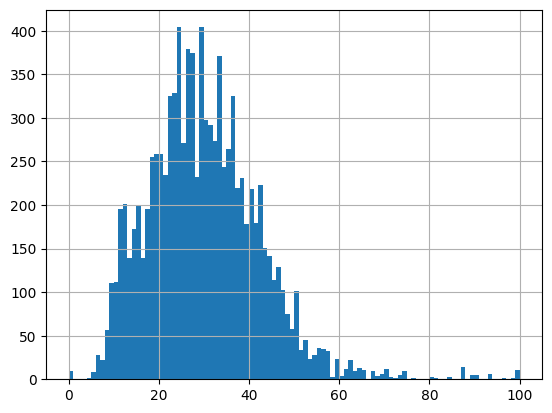

In [134]:
# Distribution of similarity scores
most_recent_quarter_results_full['name_match_score'].hist(bins=100)

<Axes: >

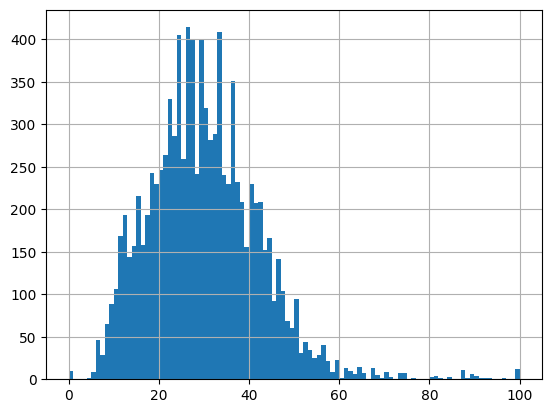

In [135]:
previous_quarters_results_full['name_match_score'].hist(bins=100)